<a href="https://colab.research.google.com/github/Pehlevan-Group/dmft_wide_networks/blob/main/Linear_DMFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random

In [2]:

def solve_AB(H, G, Delta, eta_g):
    P = H.shape[1]
    A = H *1.0
    #B = np.zeros((T,P,T))
    Gtril = jnp.tril(G, k=-1)
    H_tril = jnp.tril( H.transpose((1,3,0,2)), k=-1 ).transpose((2,0,3,1))
    G_delt = jnp.einsum('ij,jk->ijk', Gtril, Delta) # T x T x P
    H_delt = jnp.einsum('ijkl,kl->ijk', H_tril, Delta) # T x P x T
    for n in range(30):
        B = eta_g / P * jnp.einsum('ijkl,nkl->ijn', A, G_delt) # T x P x T
        A = H + eta_g / P * jnp.einsum('ijk,lmk->ijlm', B, H_delt) 
    return A, B

def solve_CD(H, G, Delta, eta_g):
    P = H.shape[1]
    Gtril = jnp.tril(G, k=-1)
    H_tril = jnp.tril( H.transpose((1,3,0,2)), k=-1 ).transpose((2,0,3,1))
    G_delt = jnp.einsum('ij,jk->ijk', Gtril, Delta) # T x T x P
    H_delt = jnp.einsum('ijkl,kl->ijk', H_tril, Delta) # T x P x T
    C = G * 1.0
    for n in range(30):
        D = eta_g / P * jnp.einsum('ij,lmj->ilm', C, H_delt)
        #D_delta = jnp.einsum('ijk,jk->ij', D, Delta)
        C = G + eta_g/P * jnp.einsum('ijk,ljk->il', D, G_delt )
    return C, D

def get_Delta(all_H, all_G, Kx, y, eta):
    T = all_H[0].shape[0]
    P = all_H[0].shape[1]
    Delta = np.zeros((T,P))
    NTK = jnp.einsum('ii,jk->ijk', all_G[0], Kx)
    for l in range(len(all_H)-1):
        NTK += jnp.einsum( 'ijik, ii->ijk', all_H[l], all_G[l+1])
    NTK += jnp.einsum('ijik->ijk',all_H[-1])
    Delta[0,:] = y
    for t in range(T-1):
        Delta[t+1,:] = Delta[t,:]- eta / P * NTK[t,:,:] @ Delta[t,:]
    return Delta


def solve_kernels(Kx, y, depth, eta, gamma, sigma=1.0, T=100, num_steps=10):
    P = Kx.shape[0]
    H0 = np.zeros((T,P,T,P))
    for t in range(T):
        for s in range(T):
            H0[t,:,s,:] = Kx
    
    all_H = [sigma**(2*(l+1)) * jnp.array(H0) for l in range(depth)]
    all_G = [sigma**(2*(depth-l)) * jnp.ones((T,T)) for l in range(depth)]
    eta_g = gamma * eta
    for n in range(num_steps):
        new_H = []
        new_G = []
        Delta = get_Delta(all_H, all_G, Kx, y, eta)
        if n == 0:
            Delta0 = 1.0 * Delta
        plt.plot(jnp.mean(Delta**2, axis = 1))
        plt.plot(jnp.mean(Delta0**2, axis=1), '--', color='black')
        plt.show()
        for l in range(depth):
            
            if l == 0:
                Hminus = H0
            else:
                Hminus = all_H[l-1]
            
            if l == depth - 1:
                Gplus = np.ones((T,T))
            else:
                Gplus = all_G[l+1]
            
            A, B = solve_AB(Hminus, Gplus, Delta, eta_g)
            # compute new H_
            Gtril = jnp.tril(Gplus, k=-1)
            H_tril = jnp.tril( Hminus.transpose((1,3,0,2)), k=-1 ).transpose((2,0,3,1))
            G_delt = jnp.einsum('ij,jk->ijk', Gtril, Delta) # T x T x P
            H_delt = jnp.einsum('ijkl,kl->ijk', H_tril, Delta) # T x P x T
            
            dH1= eta_g / P * jnp.einsum('ijk,lmk->ijlm', B, H_delt)
            G_l = all_G[l]
            Hdelta_Gl = eta_g / P * jnp.einsum('ijk,lk->ijl', H_delt, G_l) # T x P x T
            dH2 = eta_g / P *jnp.einsum('ijk,lmk->ijlm', H_delt, Hdelta_Gl)
            Hl_new = sigma**2 * Hminus + dH1 + dH1.transpose((2,3,0,1)) + dH2
            
            C, D = solve_CD(Hminus, Gplus, Delta, eta_g)
            
            dG1 = eta_g/P * jnp.einsum('ijk,ljk->il', D, G_delt )
            H_l = all_H[l]
            
            H_l_Delta = jnp.einsum('ijkl,kl->ijk', H_l, Delta)
           
            H_l_Delta_Delta = jnp.einsum('ijk,ij->ik', H_l_Delta, Delta) # T x T
           
            
            G_H_DD = eta_g / P * jnp.einsum('ij,kj->ik', Gtril, H_l_Delta_Delta)
            
            dG2 = eta_g / P * jnp.einsum('ij,kj->ik', G_H_DD, Gtril)
            
            Gl_new = sigma**2 * Gplus + dG1 + dG1.T + dG2
            new_H += [Hl_new]
            new_G += [Gl_new]
            
        for l in range(depth):
            all_H[l] = new_H[l]
            all_G[l] = new_G[l]
    return all_H, all_G



def solve_kernels_full(Kx, y, depth, eta, gamma, sigma=1.0, T=100, num_steps=10):
    P = Kx.shape[0]
    H0 = np.zeros((T,P,T,P))
    for t in range(T):
        for s in range(T):
            H0[t,:,s,:] = Kx
    
    all_H = [sigma**(2*(l+1)) * jnp.array(H0) for l in range(depth)]
    all_G = [sigma**(2*(depth-l)) * jnp.ones((T,T)) for l in range(depth)]
    all_A = [jnp.zeros((T,P,T)) for l in range(depth-1)] # Al for each l
    all_B = [jnp.zeros((T,T,P)) for l in range(depth-1)] # really the transpose B^T
    eta_g = gamma * eta
    for n in range(num_steps):
        new_H = []
        new_G = []
        new_A = []
        new_B = []
        Delta = get_Delta(all_H, all_G, Kx, y, eta)
        if n == 0:
            Delta0 = 1.0 * Delta
        #plt.plot(jnp.mean(Delta**2, axis = 1))
        #plt.plot(jnp.mean(Delta0**2, axis=1), '--', color='black')
        #plt.show()
        for l in range(depth):

            if l == 0:
                Hminus = H0
                Aminus = jnp.zeros((T,P,T))
            else:
                Hminus = all_H[l-1]
                Aminus = all_A[l-1]
            if l == depth - 1:
                Gplus = np.ones((T,T))
                Bl = jnp.zeros((T,T,P))
            else:
                Gplus = all_G[l+1]
            
                Bl = all_B[l]
            
            #A, B = solve_AB(Hminus, Gplus, Delta, eta_g)
            # compute new H_
            Gtril = jnp.tril( jnp.ones((T,T)), k=-1 ) * Gplus
            Gtril = jnp.tril( Gplus, k=-1)
            
            #H_tril = jnp.tril( Hminus.transpose((1,3,0,2)), k=-1 ).transpose((2,0,3,1))
            H_tril = jnp.einsum('ik,ijkl->ijkl', jnp.tril(jnp.ones((T,T)), k=-1), Hminus)
            G_delt = jnp.einsum('ij,jk->ijk', Gtril, Delta) # T x T x P
            H_delt = jnp.einsum('ijkl,kl->ijk', H_tril, Delta) # T x P x T
            
            # Compute C^l =  A^{l-1} + Mh^l
            Mhl = eta_g / P * H_delt
            Cl = Aminus + Mhl # (T x P) x T
            
            # Compute D^l = B^T + Mg^l
            Mgl = eta_g / P * G_delt
            Dl = Bl + Mgl  # T x (T x P)
            
            
            # compute I - CD
            Diff_CD = jnp.einsum('ik,jl->ijkl', jnp.eye(T), jnp.eye(P)) - jnp.einsum('ijk,klm->ijlm', Cl, Dl)
            
            # need to invert Diff_CD to solve Diff_CD x = H and Diff_CD y = 
            Diff_CD_inv = jnp.linalg.inv( Diff_CD.reshape((T*P,T*P)) ).reshape((T,P,T,P))
            dH1 = jnp.einsum('ijkl,mnkl->ijmn', jnp.einsum('ijkl,klmn->ijmn', Diff_CD_inv, Hminus ), Diff_CD_inv)
            
            # this thing is the new A^l estimate
            A_new = jnp.einsum('ijkl,klm->ijm', Diff_CD_inv, Cl) # (T x P) x T
            
            dH2 = jnp.einsum('ijk,lmk->ijlm',jnp.einsum('ijk,kl->ijl', A_new, Gplus), A_new)
            Hl_new = dH1 + dH2
            
            
            # Compute I - D C
            Diff_DC = jnp.eye(T) - jnp.einsum('ijk,jkl->il', Dl, Cl)
            Diff_DC_inv = jnp.linalg.inv(Diff_DC )
            
            # find (I-DC)^{-1} Gplus (I-DC)^{-1}
            dG1 = jnp.einsum( 'ij,kj->ik',  jnp.einsum('ij,jk->ik', Diff_DC_inv, Gplus ), Diff_DC_inv )
            B_minus_new = jnp.einsum('ij,jkl->ikl', Diff_DC_inv, Dl) # T x (Tx P)
            dG2 = jnp.einsum('ijk,ljk->il', jnp.einsum('ijk,jklm->ilm', B_minus_new, Hminus), B_minus_new)
            
            
            Gl_new = dG1 + dG2
            
            new_H += [Hl_new]
            new_G += [Gl_new]
            
            
            if l < depth-1:
                new_A += [A_new]
            if l > 0:
                new_B += [B_minus_new]
                
            
        for l in range(depth):
            all_H[l] = new_H[l]
            all_G[l] = new_G[l]
        for l in range(depth-1):
            all_A[l] = new_A[l]
            all_B[l] = new_B[l]
            
    return all_H, all_G, all_A, all_B




def solve_kernels_grad_indep(Kx, y, depth, eta, gamma, sigma=1.0, T=100, num_steps=10):
    P = Kx.shape[0]
    H0 = np.zeros((T,P,T,P))
    for t in range(T):
        for s in range(T):
            H0[t,:,s,:] = Kx
    
    all_H = [sigma**(2*(l+1)) * jnp.array(H0) for l in range(depth)]
    all_G = [sigma**(2*(depth-l)) * jnp.ones((T,T)) for l in range(depth)]
    all_A = [jnp.zeros((T,P,T)) for l in range(depth-1)] # Al for each l
    all_B = [jnp.zeros((T,T,P)) for l in range(depth-1)] # really the transpose B^T
    eta_g = gamma * eta
    for n in range(num_steps):
        new_H = []
        new_G = []
        new_A = []
        new_B = []
        Delta = get_Delta(all_H, all_G, Kx, y, eta)
        if n == 0:
            Delta0 = 1.0 * Delta
        #plt.plot(jnp.mean(Delta**2, axis = 1))
        #plt.plot(jnp.mean(Delta0**2, axis=1), '--', color='black')
        #plt.show()
        for l in range(depth):

            if l == 0:
                Hminus = H0
                Aminus = jnp.zeros((T,P,T))
            else:
                Hminus = all_H[l-1]
                Aminus = all_A[l-1]
            if l == depth - 1:
                Gplus = np.ones((T,T))
                Bl = jnp.zeros((T,T,P))
            else:
                Gplus = all_G[l+1]
            
                Bl = all_B[l]
            
            #A, B = solve_AB(Hminus, Gplus, Delta, eta_g)
            # compute new H_
            Gtril = jnp.tril( jnp.ones((T,T)), k=-1 ) * Gplus
            Gtril = jnp.tril( Gplus, k=-1)
            
            #H_tril = jnp.tril( Hminus.transpose((1,3,0,2)), k=-1 ).transpose((2,0,3,1))
            H_tril = jnp.einsum('ik,ijkl->ijkl', jnp.tril(jnp.ones((T,T)), k=-1), Hminus)
            G_delt = jnp.einsum('ij,jk->ijk', Gtril, Delta) # T x T x P
            H_delt = jnp.einsum('ijkl,kl->ijk', H_tril, Delta) # T x P x T
            
            # Compute C^l =  A^{l-1} + Mh^l
            Mhl = eta_g / P * H_delt
            Cl = Aminus + Mhl # (T x P) x T
            
            # Compute D^l = B^T + Mg^l
            Mgl = eta_g / P * G_delt
            Dl = Bl + Mgl  # T x (T x P)
            
            
            # compute I - CD
            Diff_CD = jnp.einsum('ik,jl->ijkl', jnp.eye(T), jnp.eye(P)) - jnp.einsum('ijk,klm->ijlm', Cl, Dl)
            
            # need to invert Diff_CD to solve Diff_CD x = H and Diff_CD y = 
            Diff_CD_inv = jnp.linalg.inv( Diff_CD.reshape((T*P,T*P)) ).reshape((T,P,T,P))
            dH1 = jnp.einsum('ijkl,mnkl->ijmn', jnp.einsum('ijkl,klmn->ijmn', Diff_CD_inv, Hminus ), Diff_CD_inv)
            
            # this thing is the new A^l estimate
            A_new = jnp.einsum('ijkl,klm->ijm', Diff_CD_inv, Cl) # (T x P) x T
            
            dH2 = jnp.einsum('ijk,lmk->ijlm',jnp.einsum('ijk,kl->ijl', A_new, Gplus), A_new)
            Hl_new = dH1 + dH2
            
            
            # Compute I - D C
            Diff_DC = jnp.eye(T) - jnp.einsum('ijk,jkl->il', Dl, Cl)
            Diff_DC_inv = jnp.linalg.inv(Diff_DC)
            
            # find (I-DC)^{-1} Gplus (I-DC)^{-1}
            dG1 = jnp.einsum( 'ij,kj->ik',  jnp.einsum('ij,jk->ik', Diff_DC_inv, Gplus ), Diff_DC_inv )
            B_minus_new = jnp.einsum('ij,jkl->ikl', Diff_DC_inv, Dl) # T x (Tx P)
            dG2 = jnp.einsum('ijk,ljk->il', jnp.einsum('ijk,jklm->ilm', B_minus_new, Hminus), B_minus_new)
            
            
            Gl_new = dG1 + dG2
            
            new_H += [Hl_new]
            new_G += [Gl_new]
            
        for l in range(depth):
            all_H[l] = new_H[l]
            all_G[l] = new_G[l]
            
    return all_H, all_G, all_A, all_B

# return first order correction
# finish today!!!
def perturb_theory(Kx, y, depth, eta, gamma, sigma=1.0, T=100):
    
    
    # initial ntk: depth + 1
    K0 = (depth+1) * Kx
    eigs, Psi = jnp.linalg.eigh( K0 )
    
    y_rot = Psi.T @ y
    
    tvals = jnp.linspace(0,T,T)
    
    Delta1 = np.zeros((T,P))
    Delta1[0,:] = y
    KNTK = np.zeros((T,P,P)) 
    
    for t in range(T):
        
        D1t = (1.0 - jnp.exp(-eigs * eta / P *t ))/eigs
        v = Psi @ jnp.diag(D1t) @ y_rot
        
        outer= jnp.outer(y_rot, y_rot / eigs)
        term1 = jnp.diag(D1t) @ outer
        sum_modes = jnp.outer(jnp.ones(P), eigs) + jnp.outer(eigs, jnp.ones(P))
        exp_curve2 = (1.0 - jnp.exp(-sum_modes * eta /P * t))/sum_modes
        term2 = outer * exp_curve2
        V = Psi @ (term1 + term2) @ Psi.T
        
        dK1 = 0.5 * Kx @ (V + V.T) @ Kx.T
        dK2 = 0.5 * jnp.outer(Kx @ v, Kx @ v)
        dK3 = 0.5 * jnp.sum( Kx * (V + V.T) ) * Kx
        dK4 = 0.5 * jnp.dot(v, Kx @ v) * Kx
        KNTK[t,:,:] = K0 + depth *(depth+1)*gamma**2 * (dK1 + dK2 + dK3 + dK4)
        
        if t > 0:
            Delta1[t,:] = Delta1[t-1,:] - eta / P * KNTK[t,:,:] @ Delta1[t-1,:]
    
    all_H_final = []
    for l in range(depth):
        Hl = Kx + (l+1) * gamma**2 * (dK1 + dK2)
        all_H_final += [Hl]
    
    return all_H_final, Delta1

def perturb_theory_full(Kx, y, depth, eta, gamma, sigma=1.0, T=100):
    
    
    # initial ntk: depth + 1
    K0 = (depth+1) * Kx
    eigs, Psi = jnp.linalg.eigh( K0 )
    
    y_rot = Psi.T @ y
    
    tvals = jnp.linspace(0,T,T)
    
    Delta1 = np.zeros((T,P))
    Delta1[0,:] = y
    KNTK = np.zeros((T,P,T,P)) 
    
    time_scales1 = jnp.ones((T, P)) - jnp.exp( - eta * jnp.outer(tvals, eigs) / P )
    v_rot = jnp.einsum('ij,j->ij', time_scales1, eigs**(-1)*y_rot) # T x P
    v = jnp.einsum('ij,kj->ik', v_rot, Psi)
    
    coeff = jnp.outer(y_rot, y_rot) * jnp.einsum('i,j->ij', jnp.ones(P), eigs**(-1)) # y_k y_l / lambda_ell
    
    V_rot_1 = jnp.einsum('ij,jk->ijk', v_rot, coeff)
    
    sum_modes = jnp.einsum('i,j->ij', eigs, np.ones(eigs.shape[0])) + jnp.einsum('i,j->ji', eigs, np.ones(eigs.shape[0]))#P x P
    #plt.imshow(sum_modes)
    #plt.show()
    time_scales2 = jnp.ones((T,P,P)) - jnp.exp(-eta* jnp.einsum('i,jk->ijk',tvals, sum_modes) / P )
    V_rot_2 = jnp.einsum('ijk,jk->ijk', time_scales2, sum_modes**(-1) * coeff)
    
    V_rot_tot = V_rot_1 + V_rot_2
    #V_rot_tot = V_rot_2
    
    # rotate into sample basis
    V = jnp.einsum('ijk,lk->ijl', V_rot_tot, Psi)
    V = jnp.einsum('ijk,lj->ilk', V, Psi)
    
    Kx_v = jnp.einsum('ij,jk->ik', v, Kx)
    dK1 =  jnp.einsum('ij,kl->ijkl', Kx_v, Kx_v) # T x P x T x P
    
    VK = jnp.einsum('ijk,kl->ijl', V, Kx)
    KVK = jnp.einsum('ijk,jl->ilk', VK, Kx)
    dK2_unsym = jnp.einsum('ijk,l->ijlk', KVK, jnp.ones(T))
    dK2 = dK2_unsym + dK2_unsym.transpose((2,3,0,1))
    
    vKv = jnp.einsum('ij,kj->ik', v, jnp.einsum('ij,jk->ik', v, Kx)) # T x T
    dK3 = jnp.einsum('ij,kl->ikjl', vKv, Kx)
    
    tr_KV = jnp.einsum('ijk,jk->i', V, Kx) 
    K_tr_KV = jnp.einsum('i,jk->ijk', tr_KV, Kx) # T x P x P
    dK4 = jnp.einsum('ijk,l->ijlk', K_tr_KV, jnp.ones(T)) + jnp.einsum('ijk,l->ljik', K_tr_KV, jnp.ones(T))
    
    KNTK = jnp.einsum('ij,kl->ikjl',jnp.ones((T,T)), K0) + depth*(depth+1)/2.0 * gamma**2 * (dK1+dK2+dK3+dK4)
    
    for t in range(T):        
        if t > 0:
            Delta1[t,:] = Delta1[t-1,:] - eta / P * KNTK[t,:,t,:] @ Delta1[t-1,:]
    
    all_H_final = []
    for l in range(depth):
        Hl = jnp.einsum('ij,kl->ikjl',jnp.ones((T,T)), Kx) + (l+1) * gamma**2 * (dK1 + dK2)
        all_H_final += [Hl]
    
    return all_H_final, Delta1


In [3]:
depth = 5
eta = 0.025
T = 100
P = 20
D = 40

# get MNIST Images...
key = random.PRNGKey(0)
X = random.normal(key,(D,P)) 
Kx = X.T @ X / D

y = -1.0*np.ones(P)
y[0:P//2]= np.ones(P//2)

Kx = jnp.array(Kx)
y = jnp.array(y)
print(y)

gamma = 1.5
sigma = 1.0

all_H, all_G,all_A,all_B = solve_kernels_full(Kx, y, depth, eta, gamma, sigma = sigma)
Delta = get_Delta(all_H, all_G, Kx, y, eta)



[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.]


[[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [9.76081530e-01 9.78594580e-01 9.94392886e-01 ... 9.82750114e-01
  9.99367218e-01 9.92164524e-01]
 [9.51322898e-01 9.56112096e-01 9.88783518e-01 ... 9.64856465e-01
  9.98850080e-01 9.83041677e-01]
 ...
 [5.46194318e-04 1.08130887e-02 4.91304034e-01 ... 1.74011728e-01
  4.75942328e-01 1.05959397e-02]
 [5.87209870e-04 1.09939353e-02 4.86560784e-01 ... 1.74076902e-01
  4.69460617e-01 1.00532712e-02]
 [6.25498003e-04 1.11522002e-02 4.81838224e-01 ... 1.74141890e-01
  4.63068853e-01 9.54579224e-03]]


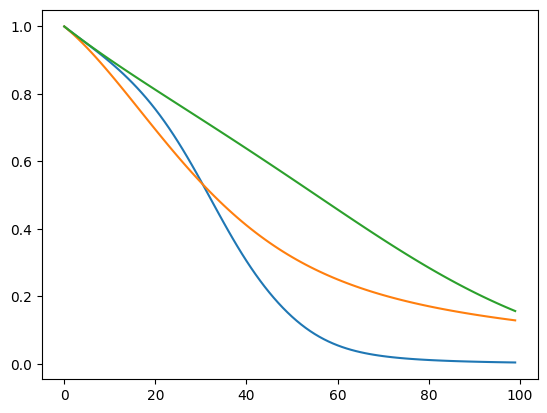

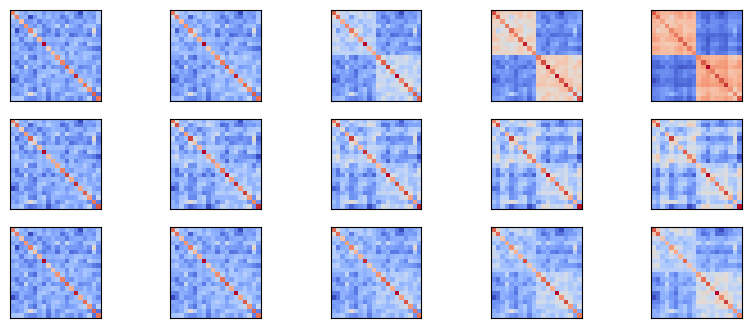

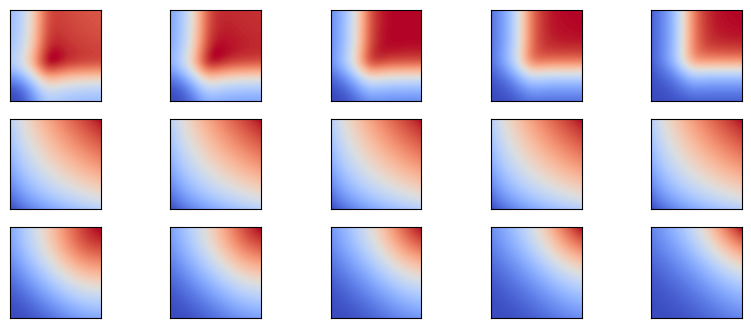

In [4]:

all_H_final_pert, Delta_pert = perturb_theory_full(Kx, y, depth, eta, gamma, T = T)
all_H_lazy, Delta_lazy = perturb_theory_full(Kx, y, depth, eta, gamma=0, T = T)

all_H_indp, all_G_indp ,_,_ = solve_kernels_grad_indep(Kx, y, depth, eta, gamma, sigma = sigma)
Delta_indp = get_Delta(all_H_indp, all_G_indp, Kx, y, eta)

print(Delta_pert**2)
plt.plot(jnp.mean(Delta**2, axis = 1))
plt.plot(jnp.mean(Delta_pert**2, axis = 1))
plt.plot(jnp.mean(Delta_indp**2, axis = 1))
plt.show()


plt.figure(figsize = (10,4))
std0 = jnp.std( all_H[0][-1,:,-1,:] )
for l, Hl in enumerate(all_H):
    plt.subplot(3,len(all_H), l+1)
    plt.imshow(Hl[-1,:,-1,:], cmap='coolwarm')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3,len(all_H), l+1+len(all_H))
    plt.imshow(all_H_final_pert[l][-1,:,-1,:], 'coolwarm')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3,len(all_H), l+1+2*len(all_H))
    plt.imshow(all_H_indp[l][-1,:,-1,:], cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])
plt.show()

plt.figure(figsize = (10,4))
std0 = jnp.std( all_H[0][-1,:,-1,:] )
for l, Hl in enumerate(all_H):
    plt.subplot(3,len(all_H), l+1)
    plt.imshow(jnp.einsum('ijkj->ik', Hl)[::-1,:], cmap='coolwarm')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3,len(all_H), l+1+len(all_H))
    plt.imshow(jnp.einsum('ijkj->ik',all_H_final_pert[l])[::-1,:], 'coolwarm')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3,len(all_H), l+1+2*len(all_H))
    plt.imshow(jnp.einsum('ijkj->ik',all_H_indp[l])[::-1,:], cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [5]:
from jax.example_libraries import optimizers
from jax import grad, jit

def construct_NN(depth,D, N = 100, sigma=1.0):
    key = random.PRNGKey(0)
    params = [sigma * random.normal(key, (N,D))]
    for l in range(depth-1):
        key, _ = random.split(key)
        params += [sigma * random.normal(key, (N,N))]
    params += [sigma * random.normal(key, (N,))]
    return params

def NN_func_eval(params, X):
    h = params[0] @ X / jnp.sqrt(X.shape[0])
    N = params[0].shape[0]
    for l in range(1,len(params)-1):
        h = 1/jnp.sqrt(N) * params[l] @ h
    return 1/N * jnp.dot(params[-1], h)

def get_NNGP_NN(params,X):
    all_H = []
    N = params[0].shape[0]
    h = params[0] @ X / jnp.sqrt(X.shape[0])
    all_H += [1/N * h.T @ h]
    for l in range(1,len(params)-1):
        h = 1/jnp.sqrt(N) * params[l] @ h
        all_H += [1/N * h.T @ h]
    return all_H


def optimize_NN(X,y,params, eta,gamma):
    N = params[0].shape[0]
    opt_init, opt_update, get_params = optimizers.sgd(eta * gamma**2 * N)
    opt_state = opt_init(params)
    params0 = params
    #loss = jit(lambda params: jnp.sum( ( 1/gamma*(NN_func_eval(params, X)-NN_func_eval(params0,X)) - y )**2 ))
    loss = jit(lambda params: 0.5*jnp.mean( ( 1/gamma*NN_func_eval(params, X)- y )**2 ))
    grad_fn = jit(grad(loss,0))
    losses = []
    all_h_t = np.zeros((len(params)-1, N, T, P))
    for t in range(100):
        losses += [ 2*loss(get_params(opt_state)) ]
        opt_state = opt_update(t, grad_fn(get_params(opt_state)), opt_state)
        ht,_ = get_features(get_params(opt_state), params0, X, y)
        for l in range(len(params)-1):
            all_h_t[l,:,t,:] = ht[l]
    return losses, get_params(opt_state), all_h_t

def get_features(params, params0, X, y):
    all_h = []
    all_chi = []
    h = params[0] @ X / jnp.sqrt(X.shape[0])
    chi = params0[0] @ X / jnp.sqrt(X.shape[0])
    all_chi += [chi]
    L = len(params)-1
    N = params[0].shape[0]
    for l in range(L-1):
        all_h += [h]
        h = params[l+1] @ h / jnp.sqrt(N)
        chi = params0[l+1] @ h / jnp.sqrt(N)
        all_chi += [chi]
    all_h += [h]
    return all_h, all_chi

def get_features_forward_back(params, params0, X, y):
    all_h = []
    all_chi = []
    h = params[0] @ X / jnp.sqrt(X.shape[0])
    chi = params0[0] @ X / jnp.sqrt(X.shape[0])
    all_chi += [chi]
    L = len(params)-1
    N = params[0].shape[0]
    for l in range(L-1):
        all_h += [h]
        h = params[l+1] @ h / jnp.sqrt(N)
        chi = params0[l+1] @ h / jnp.sqrt(N)
        all_chi += [chi]
    all_h += [h]
    
    g = params[-1]
    xi = params0[-1]
    all_g = [g]
    all_xi = [xi] 
    for l in range(L-1):
        all_g.insert(0, )
    
    return all_h, all_chi

N = 2200
params = construct_NN(depth, D, N, sigma = sigma)

all_expt =[]
all_H_final_expt = []

losses, params_final, all_h_t = optimize_NN(X,y, params, gamma=gamma, eta = eta)
all_expt += [losses]

all_h, all_chi = get_features(params_final, params, X, y)


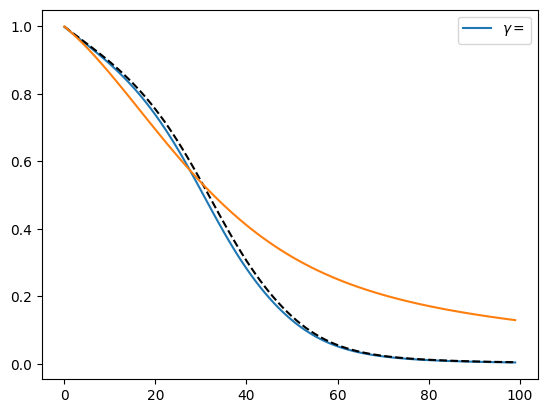

[[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [9.76081530e-01 9.78594580e-01 9.94392886e-01 ... 9.82750114e-01
  9.99367218e-01 9.92164524e-01]
 [9.51322898e-01 9.56112096e-01 9.88783518e-01 ... 9.64856465e-01
  9.98850080e-01 9.83041677e-01]
 ...
 [5.46194318e-04 1.08130887e-02 4.91304034e-01 ... 1.74011728e-01
  4.75942328e-01 1.05959397e-02]
 [5.87209870e-04 1.09939353e-02 4.86560784e-01 ... 1.74076902e-01
  4.69460617e-01 1.00532712e-02]
 [6.25498003e-04 1.11522002e-02 4.81838224e-01 ... 1.74141890e-01
  4.63068853e-01 9.54579224e-03]]


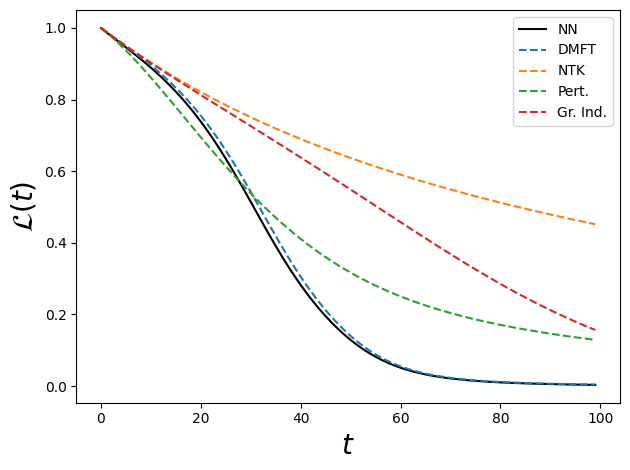

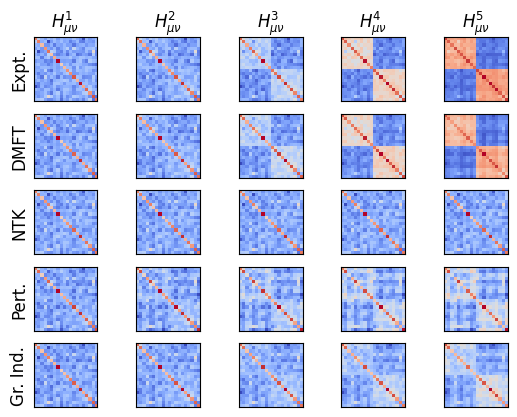

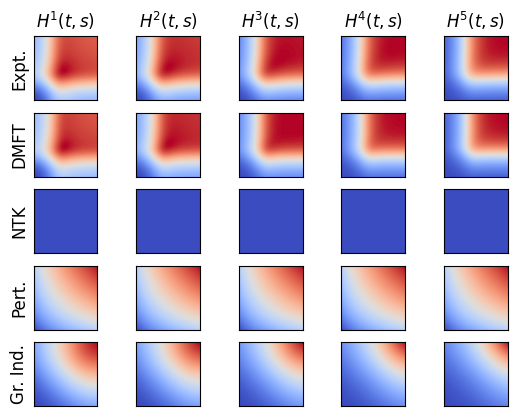

In [8]:
plt.plot(losses, label = r'$\gamma = %0.1f$')
plt.plot(jnp.mean(Delta**2,axis=1), '--', color = 'black')
plt.plot(jnp.mean(Delta_pert**2,axis = 1))
all_H_final_expt += [get_NNGP_NN(params_final, X)]
plt.legend()
plt.show()

print(Delta_pert**2)
plt.figure()
plt.plot(losses, color = 'black', label = r'NN')
plt.plot(jnp.mean(Delta**2, axis = 1), '--', label = 'DMFT')
plt.plot(jnp.mean(Delta_lazy**2, axis = 1), '--', label = 'NTK')
plt.plot(jnp.mean(Delta_pert**2, axis = 1), '--', label = 'Pert.')
plt.plot(jnp.mean(Delta_indp**2, axis = 1), '--', label = 'Gr. Ind.')

plt.legend()
plt.ylabel(r'$\mathcal{L}(t)$',fontsize = 20)
plt.xlabel(r'$t$',fontsize = 20)
plt.tight_layout()
plt.show()


#plt.figure(figsize = (12,10))
plt.figure()
std0 = jnp.std( all_H[0][-1,:,-1,:] )
for l, Hl in enumerate(all_H):
    h = all_h[l]
    H_expt = h.T @ h / h.shape[0]
    plt.subplot(5,len(all_H), l+1)
    plt.title(r'$H^{%d}_{\mu \nu}$' % (l+1),fontsize = 12)
    plt.imshow(H_expt, cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])
    if l == 0:
        plt.ylabel('Expt.',fontsize = 12)
    plt.subplot(5,len(all_H), l+1+len(all_H))
    plt.imshow(Hl[-1,:,-1,:], cmap='coolwarm')
    plt.xticks([])
    plt.yticks([])
    if l == 0:
        plt.ylabel('DMFT',fontsize = 12)
    plt.subplot(5,len(all_H), l+1+2*len(all_H))
    plt.imshow(all_H_lazy[l][-1,:,-1,:], cmap='coolwarm')
    plt.xticks([])
    plt.yticks([])
    if l == 0:
        plt.ylabel('NTK',fontsize = 12)
    plt.subplot(5,len(all_H), l+1+3*len(all_H))
    plt.imshow(all_H_final_pert[l][-1,:,-1,:], 'coolwarm')
    plt.xticks([])
    plt.yticks([])
    if l == 0:
        plt.ylabel('Pert.',fontsize = 12)
    plt.subplot(5,len(all_H), l+1+4*len(all_H))
    plt.imshow(all_H_indp[l][-1,:,-1,:], cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])
    if l == 0:
        plt.ylabel('Gr. Ind.',fontsize = 12)

#plt.tight_layout()
plt.show()


for l, Hl in enumerate(all_H):
    h = all_h_t[l,:,:,:] # N x T x P
    H_expt = jnp.einsum('ijk,ilk->jl', h,h) / h.shape[0]
    plt.subplot(5,len(all_H), l+1)
    plt.title(r'$H^{%d}(t,s)$' % (l+1),fontsize = 12)
    plt.imshow(H_expt[::-1,:], cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])
    if l == 0:
        plt.ylabel('Expt.',fontsize = 12)
    plt.subplot(5,len(all_H), l+1+len(all_H))
    
    plt.imshow(jnp.einsum('ijkj->ik', Hl)[::-1,:], cmap='coolwarm')
    plt.xticks([])
    plt.yticks([])
    if l == 0:
        plt.ylabel('DMFT',fontsize = 12)
    plt.subplot(5,len(all_H), l+1+2*len(all_H))
    plt.imshow(jnp.einsum('ijkj->ik',all_H_lazy[l])[::-1,:], cmap='coolwarm')
    plt.xticks([])
    plt.yticks([])
    if l == 0:
        plt.ylabel('NTK',fontsize = 12)
    plt.subplot(5,len(all_H), l+1+3*len(all_H))
    plt.imshow(jnp.einsum('ijkj->ik',all_H_final_pert[l])[::-1,:], 'coolwarm')
    plt.xticks([])
    plt.yticks([])
    if l == 0:
        plt.ylabel('Pert.',fontsize = 12)
    plt.subplot(5,len(all_H), l+1+4*len(all_H))
    plt.imshow(jnp.einsum('ijkj->ik', all_H_indp[l])[::-1,:], cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])
    if l == 0:
        plt.ylabel('Gr. Ind.',fontsize = 12)

plt.show()


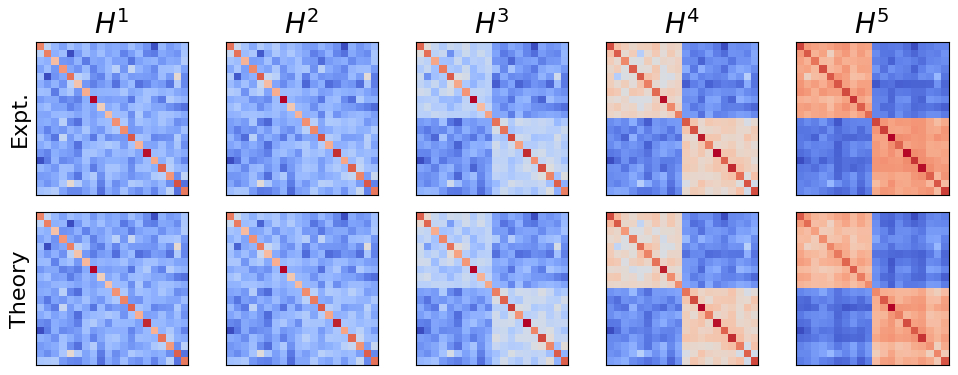

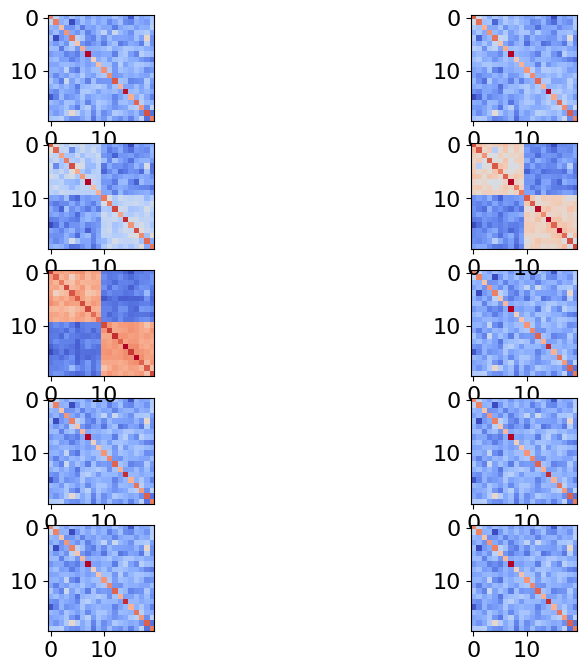

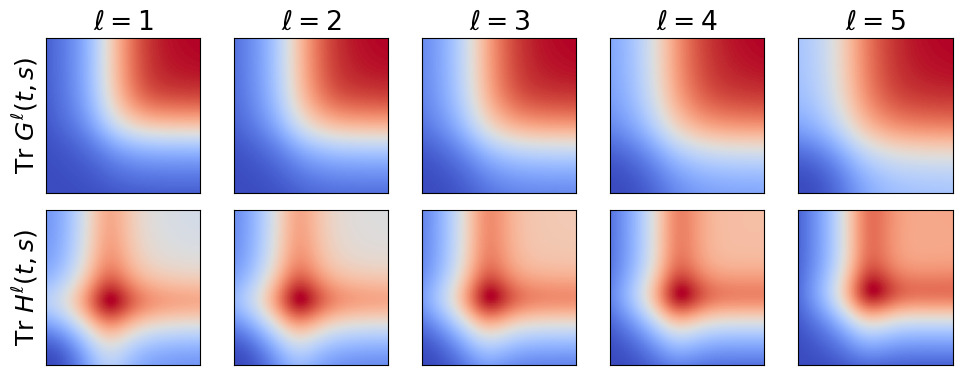

In [9]:
plt.figure(figsize = (10,4))
plt.rcParams.update({'font.size': 16})

for l, h in enumerate(all_h):
    H = h.T @ h / h.shape[0]
    plt.subplot(2, len(all_h), l+1)
    plt.imshow(H, cmap='coolwarm')
    plt.xticks([])
    plt.yticks([])
    if l == 0:
        plt.ylabel('Expt.')
    plt.title(r'$H^{%d}$' % (l+1),fontsize = 20)
    #if l <= len(all_h)-1:
    #    plt.colorbar(fraction = 0.05, format = '%0.1f')
    plt.subplot(2,len(all_h), l+1+len(all_h))
    plt.imshow(all_H[l][-1,:,-1,:], cmap='coolwarm')
    if l == 0:
        plt.ylabel('Theory')
    plt.xticks([])
    plt.yticks([])
    #if l <= len(all_h)-1:
    #    plt.colorbar(fraction = 0.05, format = '%0.1f')
plt.tight_layout()
plt.show()

plt.figure(figsize = (10,8))
for l, h in enumerate(all_chi):
    H = h.T @ h / h.shape[0]
    plt.subplot(len(all_h),2, l+1)
    plt.imshow(H, cmap='coolwarm')
    plt.subplot(len(all_h),2, l+1+len(all_h))
    plt.imshow(all_H[l][0,:,0,:], cmap='coolwarm')
plt.show()

plt.figure(figsize = (10,4))
for l, G in enumerate(all_G):
    plt.subplot(2,len(all_G),l+1)
    plt.imshow(G[::-1,:], cmap='coolwarm')
    plt.title(r'$\ell = %d$' % (l+1))
    if l == 0:
        plt.ylabel(r'Tr $G^\ell(t,s)$',fontsize =18)
    plt.xticks([])
    plt.yticks([])
    #if l <= len(all_h)-1:
    #    plt.colorbar(fraction = 0.05, format = '%d')
    plt.subplot(2,len(all_G), l+1+len(all_G))
    plt.imshow(all_H[l][::-1,0,:,0], cmap='coolwarm')
    if l == 0:
        plt.ylabel(r'Tr $H^\ell(t,s)$',fontsize=18)
    plt.xticks([])
    plt.yticks([])
    #if l <= len(all_h)-1:
    #    plt.colorbar(fraction = 0.05, format = '%0.2f')
plt.tight_layout()
plt.show()
#print(jnp.mean((G - G.T)**2))



## $\gamma$ Sweep and Accuracy measurement

In [10]:
gamma_vals = np.linspace(0.25, 1.5, num = 15)

all_ht_expt = []

for i,gamma in enumerate(gamma_vals):
    # train NN
    losses, params_final, all_h_t = optimize_NN(X,y, params, gamma=gamma, eta = eta)
    all_ht_expt += [all_h_t]

    
err_DMFT = []
err_pert = []
err_lazy = []
err_indp = []

for i,gamma in enumerate(gamma_vals):
    all_H, _, _ , _ = solve_kernels_full(Kx, y, depth, eta, gamma, sigma = sigma)
    all_H_pert, _ = perturb_theory_full(Kx, y, depth, eta, gamma, T = T)
    all_H_lazy, _ = perturb_theory_full(Kx, y, depth, eta, gamma=0, T = T)
    all_H_indp, _ ,_,_ = solve_kernels_grad_indep(Kx, y, depth, eta, gamma, sigma = sigma)
    
    ht_i = all_ht_expt[i]
    errs_dmft_layers = []
    errs_pert_layers = []
    errs_lazy_layers = []
    errs_indp_layers = []

    for l,Hl in enumerate(all_H):
        hl = ht_i[l,:,:,:]
        Hexpt = jnp.einsum('ijk,ilm->jklm', hl, hl) / hl.shape[0]
        errs_dmft_layers += [jnp.sum(Hexpt*Hl)/jnp.sqrt( jnp.sum(Hexpt**2) * jnp.sum(Hl**2))]
        errs_pert_layers += [jnp.sum(Hexpt*all_H_pert[l])/jnp.sqrt(jnp.sum(Hexpt**2)*jnp.sum(all_H_pert[l]**2))]
        errs_lazy_layers += [jnp.sum(Hexpt*all_H_lazy[l])/jnp.sqrt(jnp.sum(Hexpt**2)*jnp.sum(all_H_lazy[l]**2))]
        errs_indp_layers += [jnp.sum(Hexpt*all_H_indp[l])/jnp.sqrt(jnp.sum(Hexpt**2)*jnp.sum(all_H_indp[l]**2))]
    
    err_DMFT += [jnp.mean(jnp.array(errs_dmft_layers))]
    err_pert += [jnp.mean(jnp.array(errs_pert_layers))]
    err_lazy += [jnp.mean(jnp.array(errs_lazy_layers))]
    err_indp += [jnp.mean(jnp.array(errs_indp_layers))]



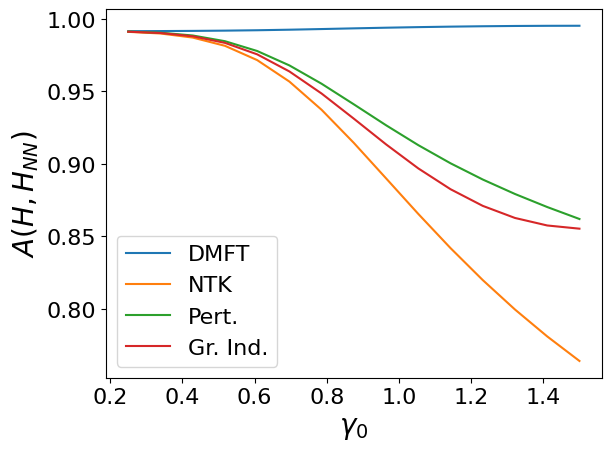

In [12]:
plt.plot(gamma_vals, err_DMFT, label = 'DMFT')
plt.plot(gamma_vals, err_lazy, label = 'NTK')
plt.plot(gamma_vals, err_pert, label = 'Pert.')
plt.plot(gamma_vals, err_indp, label = 'Gr. Ind.')
plt.xlabel(r'$\gamma_0$',fontsize =20)
plt.ylabel(r'$A(H, H_{NN})$',fontsize=20)
#plt.ylabel(r'$|H-H_{NN}|^2/|H_{NN}|^2$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.show()


## Depth Sweep

In [17]:
gamma = 1.4
depths = [2,3,4,5]
all_Delta  = []
all_expt = []
all_all_H = []
all_H_expt = []
for depth in depths:
    all_H, all_G,_,_ = solve_kernels_full(Kx, y, depth, eta, gamma, sigma = sigma)
    all_Delta += [ get_Delta(all_H, all_G, Kx, y, eta) ]
    params = construct_NN(depth, D, N, sigma = sigma)
    losses, params_final, all_h_t = optimize_NN(X, y, params, gamma=gamma, eta = eta)
    all_expt += [losses]
    all_all_H += [all_H]
    H_expt = []
    for l,hl in enumerate(all_h_t):
        H_expt += [jnp.einsum('ijk,ilm->jklm',hl,hl) / hl.shape[0]]
    all_H_expt += [H_expt]

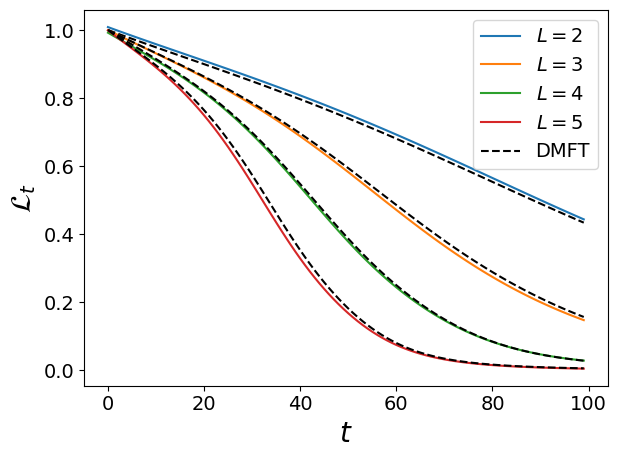

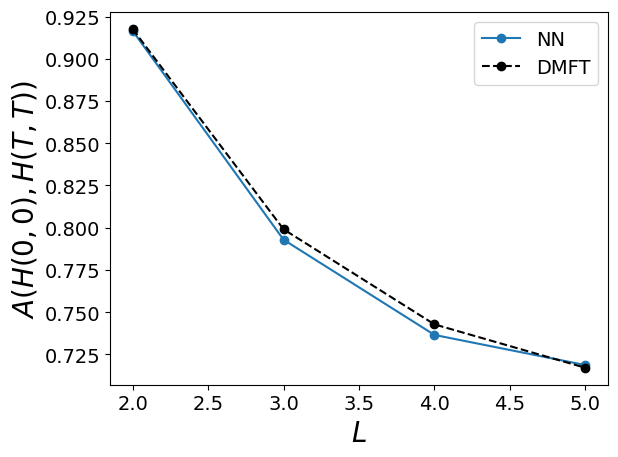

In [18]:
plt.rcParams.update({'font.size': 14})
for i, l in enumerate(depths):
    plt.plot(all_expt[i], label = r'$L = %d$' % l)
    if i == len(depths)-1:
        plt.plot(jnp.mean(all_Delta[i]**2,axis=1), '--', color = 'black' ,label = 'DMFT')
    else:
        plt.plot(jnp.mean(all_Delta[i]**2,axis=1), '--', color = 'black')
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'$\mathcal{L}_t$',fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()

mean_moves = []
mean_moves_expt = []
for i,Hi in enumerate(all_all_H):
    
    #movements = [ jnp.mean((H[-1,:,-1,:] - H[0,:,0,:])**2 ) for H in Hi]
    #movements_expt = [ jnp.mean( (H[-1,:,-1,:] - H[0,:,0,:])**2 ) for H in all_H_expt[i] ]
    movements = [jnp.sum(H[-1,:,-1,:]*H[0,:,0,:])/jnp.sqrt(jnp.sum(H[0,:,0,:]**2)*jnp.sum(H[-1,:,-1,:]**2)) for H in Hi]
    movements_expt = [jnp.sum(H[-1,:,-1,:]*H[0,:,0,:])/jnp.sqrt(jnp.sum(H[0,:,0,:]**2)*jnp.sum(H[-1,:,-1,:]**2)) for H in all_H_expt[i]]

    mean_moves += [np.mean(movements)]
    mean_moves_expt += [np.mean(movements_expt)]
    
plt.plot(depths, mean_moves_expt, marker = 'o', label = 'NN')
plt.plot(depths, mean_moves, '--', marker = 'o', label ='DMFT', color = 'black')
plt.xlabel(r'$L$',fontsize=20)
plt.legend()
plt.ylabel(r'$A(H(0,0), H(T,T))$',fontsize = 20)
plt.tight_layout()
plt.show()
    

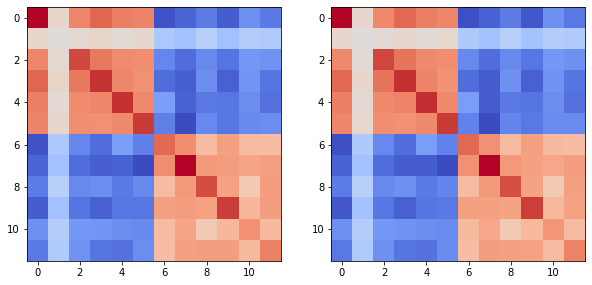

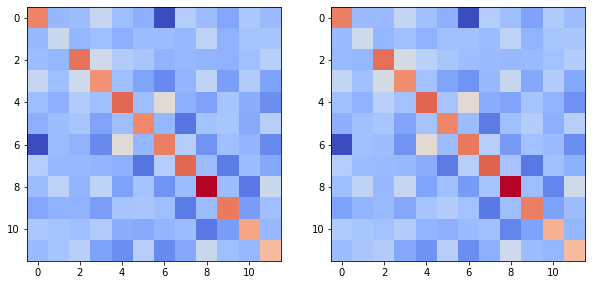

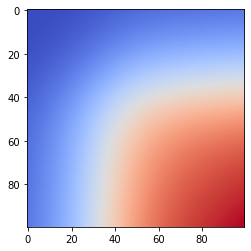

7.383306e-13


In [ ]:
plt.figure(figsize = (10,8))
for l, h in enumerate(all_h):
    H = h.T @ h / h.shape[0]
    plt.subplot(len(all_h),2, l+1)
    plt.imshow(H, cmap='coolwarm')
    plt.subplot(len(all_h),2, l+1+len(all_h))
    plt.imshow(all_H[l][-1,:,-1,:], cmap='coolwarm')
plt.show()

plt.figure(figsize = (10,8))
for l, h in enumerate(all_chi):
    H = h.T @ h / h.shape[0]
    plt.subplot(len(all_h),2, l+1)
    plt.imshow(H, cmap='coolwarm')
    plt.subplot(len(all_h),2, l+1+len(all_h))
    plt.imshow(all_H[l][0,:,0,:], cmap='coolwarm')
plt.show()

for l, G in enumerate(all_G):
    plt.imshow(G,  cmap='coolwarm')
    plt.show()
    print(jnp.mean((G - G.T)**2))

## Test Gradient Independence Approximation

In [ ]:
depths = [2,3,4,5]
all_Delta  = []
all_expt = []
all_all_H = []
for depth in depths:
    all_H, all_G,_,_ = solve_kernels_grad_indep(Kx, y, depth, eta, gamma, sigma = sigma)
    all_Delta += [ get_Delta(all_H, all_G, Kx, y, eta) ]
    params = construct_NN(depth, D, N, sigma = sigma)
    losses, params_final = optimize_NN(X,y, params, gamma=gamma, eta = eta)
    all_expt += [losses]
    all_all_H += [all_H]

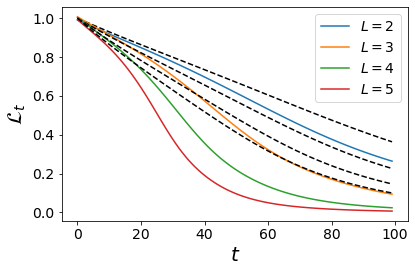

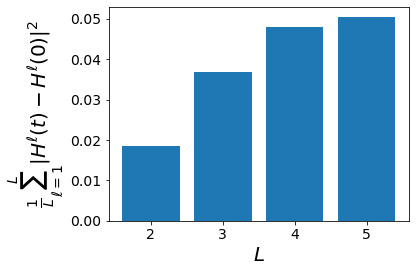

In [ ]:
plt.rcParams.update({'font.size': 14})
for i, l in enumerate(depths):
    plt.plot(all_expt[i], label = r'$L = %d$' % l)
    plt.plot(jnp.mean(all_Delta[i]**2,axis=1), '--', color = 'black')
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'$\mathcal{L}_t$',fontsize=20)
plt.legend()
plt.tight_layout()
plt.savefig('final_theory_figs/loss_grad_indep_linear_vary_depth_gamma_%d.pdf' % (10*gamma))
plt.show()

mean_moves = []
for i,Hi in enumerate(all_all_H):
    
    movements = [ jnp.mean((H[-1,:,-1,:] - H[0,:,0,:])**2 ) for H in Hi]
    mean_moves += [np.mean(movements)]

plt.bar(depths, mean_moves)
plt.xlabel(r'$L$',fontsize=20)
plt.ylabel(r'$\frac{1}{L} \sum_{\ell=1}^L |H^\ell(t) - H^\ell(0)|^2$',fontsize = 20)
plt.tight_layout()
plt.savefig('final_theory_figs/kernel_movement_grad_indep_linear_vary_depth_%d.pdf' % (10*gamma))
plt.show()

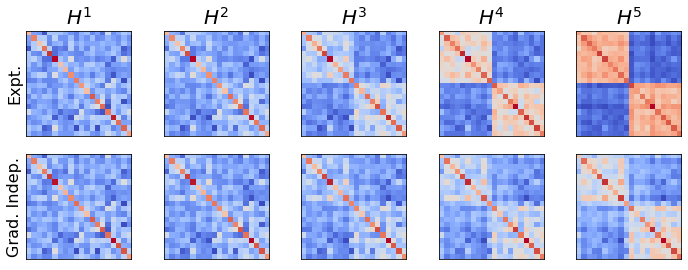

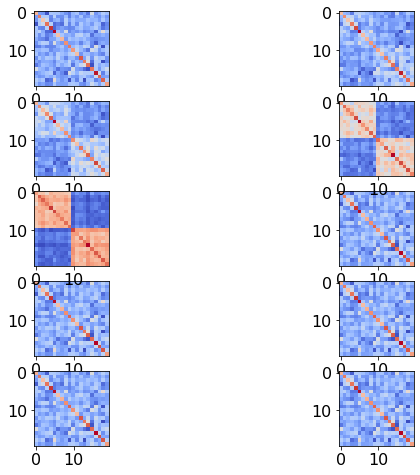

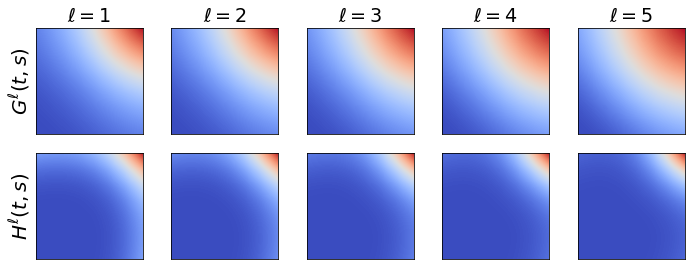

In [ ]:
all_h, all_chi = get_features(params_final, params, X, y)
plt.figure(figsize = (10,4))
plt.rcParams.update({'font.size': 16})

for l, h in enumerate(all_h):
    H = h.T @ h / h.shape[0]
    plt.subplot(2, len(all_h), l+1)
    plt.imshow(H, cmap='coolwarm')
    plt.xticks([])
    plt.yticks([])
    if l == 0:
        plt.ylabel('Expt.')
    plt.title(r'$H^{%d}$' % (l+1),fontsize = 20)
    plt.subplot(2,len(all_h), l+1+len(all_h))
    plt.imshow(all_H[l][-1,:,-1,:], cmap='coolwarm')
    if l == 0:
        plt.ylabel('Grad. Indep.')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

plt.figure(figsize = (10,8))
for l, h in enumerate(all_chi):
    H = h.T @ h / h.shape[0]
    plt.subplot(len(all_h),2, l+1)
    plt.imshow(H, cmap='coolwarm')
    plt.subplot(len(all_h),2, l+1+len(all_h))
    plt.imshow(all_H[l][0,:,0,:], cmap='coolwarm')
plt.show()

plt.figure(figsize = (10,4))
for l, G in enumerate(all_G):
    plt.subplot(2,len(all_G),l+1)
    plt.imshow(G[::-1,:],  cmap='coolwarm')
    plt.title(r'$\ell = %d$' % (l+1))
    if l == 0:
        plt.ylabel(r'$G^\ell(t,s)$',fontsize =20)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(2,len(all_G), l+1+len(all_G))
    plt.imshow(all_H[l][::-1,0,:,0], cmap='coolwarm')
    if l == 0:
        plt.ylabel(r'$H^\ell(t,s)$',fontsize=20)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()
